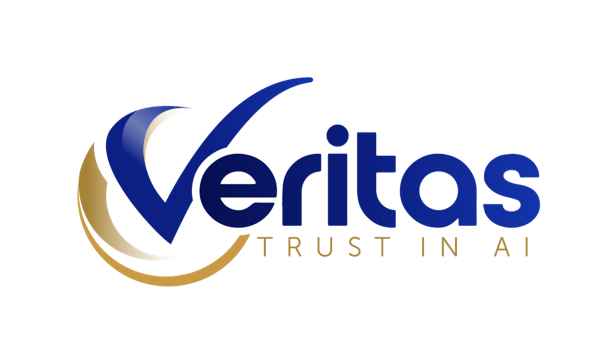

# Veritas Diagnosis Tool Demo : Predictive Underwriting Classification Model 
    
<p>   
    The <b>Veritas toolkit</b> is comprised of diagnosis tool and assessment tool.
    This scenario is to build a predictive underwriting model and use daignosis tool to evaluate model & produce
    the model artifact required by assessment tool to generate the fairness & transparency assessment report.
</p>    
<p>    
    Predictive Underwriting model is a binary classification model to predict whether to award insurance policy by assessing risk. <br/>
    Steps to perform: <br/>
    1. Loading Data and Model <br/>  
    2. Fairness & Transparency Diagnosis <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.1 compute performance and fairness metrics <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.2 compute trade off analysis <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.3 compute feature importance analysis <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.6 compute transparency analysis <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.7 save results in json artifact v1<br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.4 compute root cause analysis <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.5 perform bias mitigation & rerun fairness assessment <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.7 save results in json artifact v2<br/>
    
</p>

# 1. Loading PUW Data and Model

## Importing Libraries 

In [ ]:
#!pip install imblearn
#If facing SSL related errors, the below can be used instead.
#!pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org imblearn

In [71]:
import numpy as np
import pandas as pd
import pickle
import sys  
from pathlib import Path
# making veritas available in search path
sys.path.append('../../')
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
import os
sys.path.insert(0, os.getcwd().split('veritastool\\examples')[0])
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import imblearn
np.seterr(divide='ignore', invalid='ignore')
SEED = 123
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading Data  


In [72]:
pth = os.path.abspath('.')

#Load Predictive Underwriting Data
file = os.path.join(pth, 'data',"underwriting_dict.pickle") 
input_file = open(file, "rb")
puw = pickle.load(input_file)
input_file.close()

#Model Contariner Parameters
y_true = np.array(puw["y_test"])
y_pred = np.array(puw["y_pred"])
y_train = np.array(puw["y_train"])
y_prob = puw["y_prob"]
x_train = puw["X_train"]
x_test = puw["X_test"]

### Data Exploration

In [73]:
print("No of rows: {} \nNo. of columns: {}".format(x_train.shape[0],x_train.shape[1]))
x_train.head()

No of rows: 18499 
No. of columns: 20


,BMI,age,annual_premium,new_pol_last_3_years,num_life_policies,num_pa_policies,num_sp_policies,number_exclusions,payout_amount,policy_duration,purchase_recency,tenure,gender,latest_purchase_distribution_channel,latest_purchase_product_category,marital_status,nationality,postcode,race,smoking
0,2,40.0,555.18140,0.0,1.0,0.0,0.0,0.0,9853.81400,110.93384,43.247840,8.469562,0,0,4,3,1,5,2,0
1,0,42.0,460.79140,0.0,1.0,0.0,0.0,0.0,5412.07370,75.93384,61.247840,5.135544,1,0,0,1,1,6,1,0
2,0,35.0,935.56146,0.0,1.0,0.0,0.0,1.0,8494.87500,71.93384,71.247840,5.990438,0,0,0,1,1,14,1,0
3,0,39.0,231.82141,0.0,1.0,0.0,0.0,0.0,8158.42430,107.93384,83.914505,9.565387,0,0,0,3,0,16,1,0
4,0,38.0,231.82141,1.0,1.0,0.0,1.0,0.0,595.38889,86.93384,47.247840,5.028083,0,0,1,3,1,5,3,0


Class imbalance

In [74]:
counts = pd.Series(y_train).value_counts()
print("count of neg class: {} \ncount of pos class: {}".format(counts[0],counts[1]))

count of neg class: 3199 
count of pos class: 15300


### Data Preprocessing

In [75]:
# Select the object columns
obj_cols = x_train.select_dtypes(include='object').columns

for col in obj_cols:
    le = LabelEncoder()
    le.fit(pd.concat([x_train[col], x_test[col]]))
    x_train[col] = le.transform(x_train[col])
    x_test[col] = le.transform(x_test[col])

# Resampling step
under = RandomUnderSampler(sampling_strategy=0.5, random_state=SEED)
over = SMOTE(random_state=SEED)
pipe = imblearn.pipeline.Pipeline([
    ('under', under),
    ('over', over)
])
print(f"Class distribution before: {np.unique(y_train, return_counts=True)}")
x_train_resampled, y_train_resampled = pipe.fit_resample(x_train, y_train)
print(f"Class distribution after: {np.unique(y_train_resampled, return_counts=True)}")

x_train_final = pd.DataFrame(x_train_resampled, columns=x_train.columns)
x_test_final = x_test

Class distribution before: (array([0., 1.]), array([ 3199, 15300], dtype=int64))
Class distribution after: (array([0., 1.]), array([6398, 6398], dtype=int64))


## Building Model

### Loading & Testing Model

In [76]:
model = puw["model"]
model_name = "pred_underwriting"
model_type = "classification"

In [78]:
test_preds = model.predict(x_test_final)
print("Balanced Accuracy: {}".format(round(balanced_accuracy_score(y_true,test_preds),3)))

Balanced Accuracy: 0.942


# 2. Fairness & Transparency Diagnosis

## Import Veritas Library

Veritas Library use case object creation includes two step. In the first step, Model_Container object is created with generic machine learning model inputs. In the second step, use case object is created with Model_Container object and use case specific inputs. Predictive Underwriting is showcased in this notebook.

In [79]:
from veritastool.model.modelwrapper import ModelWrapper
from veritastool.model.model_container import ModelContainer
from veritastool.usecases.predictive_underwriting import PredictiveUnderwriting

## Set up protected variables

In [80]:
p_grp = {'gender': [[1]], 'race': [[1]], 'gender-race':'max_bias'} # Include intersectional fairness
up_grp = {'gender': [[0]], 'race': [[2, 3]] }

In [81]:
# Multi-valued protected variable

# Ordinal Mapping
# 'CAUCASIAN' - 0
# 'CHINESE'   - 1
# 'INDIAN'    - 2
# 'MALAY'     - 3
# 'OTHERS'    - 4

x_train['race'].value_counts()

1    15373
2     1801
3      949
4      368
0        8
Name: race, dtype: int64

In [82]:
# Max bias
# Gender_Race Pos_Lbls Neg_Lbls Perf Metric
# 0_1           1710     263       0.89       -> worst group
# 1_1           1485     409       0.95       -> best group 
# 0_2           181      34        0.95
# 0_3           108      9         0.99
#layman explanation

## Initializing Veritas Library

In [83]:
#Create Model Container 
container = ModelContainer(y_true,  p_grp, model_type, model_name, y_pred, y_prob, y_train, x_train=x_train, \
                           x_test=x_test_final, model_object=model, up_grp=up_grp)

<h5 align="center">Table 1: Model Container parameters   </h5>

| Var Name    | Category       |Sub-category   | Description   |  Value        |  Compulsory   |
| :---        |    :----:      |   :----:      |          ---: |          ---: |        ---: |
| y_true      | data           | testing       | test set labels| array([0, 1, 1, ..., 1])   |Yes|
| y_pred      | data           | testing       | test set predicted labels | array([0, 1, 1, ..., 1])   |Yes|
| y_prob      | data           | testing       | test set predicted probabilities | array([0.56, 0.33, 0.11, ..., 0.98])|No|
| x_test      | data           | testing       | test set features | -      |No|
| y_train     | data           | training      | train set labels      | array([0, 1, 1, ..., 1])   |No|
| x_train     | data           | training      | train set features |-      |No|
| p_var       | protected vars |    -          | list of protected vars| [ 'SEX', 'MARRIAGE' ]      |Yes|
| p_grp       | protected vars |    -          | list of privileged groups| { 'SEX': [ 1 ] , 'MARRIAGE': [ 1 ] }   |Yes|
| model_obj   | model          |    -          | model to assess| -      |No|
| model_type  | model          |    -          | type of model | 'credit'    |Yes|
| model_name  | model          |    -          | name of model | 'credit scoring'   |No|
| feature_imp | model          |    -          | list of feature imps for model| -   |No|


In [84]:
#Create Use Case Object
pred_underwriting_obj= PredictiveUnderwriting(model_params = [container], fair_threshold = 80, fair_concern = "inclusive", \
                                        fair_priority = "benefit", fair_impact = "normal", fair_metric_type='ratio',\
                                               tran_index=[1,2,3], tran_max_sample = 50, tran_max_display = 10, \
                                                      tran_pdp_feature = ['age','payout_amount'])

In [ ]:
pred_underwriting_obj.model_params[0].p_grp,pred_underwriting_obj.model_params[0].up_grp

<h5 align="center">Table 2: Predictive Underwriting parameters   </h5>

| Var Name    | Category       | Description   |  Value        |Compulsory|
| :---        |    :----:      |          ---: |          ---: |---:|
| model_params| model containers | list of model containers | -  |Yes|
| fair_metric_name| metric name |primary fairness metric | "auto" or any of supported ones <br/> like "equal_opportunity" |No|
| perf_metric_name      | metric name |primary performance metric |"balanced_acc"   |No|
| fair_concern | fair_metric selection | most concerned cohort |"eligible" or "inclusive" or "both" |No|
| fair_priority| fair_metric selection|top priority to be for fairness assessment | "benefit" or "harm" |No|
| fair_impact  | fair_metric selection |impact magnitude and type | "normal" or "significant" or "selective"   |No|
| fair_metric_type  | fair_metric selection | type of metric | "difference" or "ratio"  |No|
| fair_threshold | fairness metric thresholding |threshold used for assessment|actual value [0,1] or p% rule (1,100]|Yes|
| tran_index      | transparency parameter |index for local interpretability plot |list of integers   |No|
| tran_max_sample      | transparency parameter |sampling size for transparency analysis |float value between 0 and 1 (treated as <br/> percentage of rows)  or  int treated as #rows   |No|
| tran_pdp_feature      | transparency parameter |feature list for pdp plots |list of features   |No|
| tran_pdp_target      | transparency parameter |class label for pdp plots(required for uplift model) |string |No|
| tran_max_display      | transparency parameter |#features to be displayed in the transparency plots |int    |No|

## Starting Fairness diagnosis

In [85]:
pred_underwriting_obj.evaluate()

Evaluate performance:   0%|          


Class Distribution
	pos_label                                                          82.681%
	neg_label                                                          17.319%


Performance Metrics
	Selection Rate                                             0.816 +/- 0.012
	Accuracy                                                   0.959 +/- 0.005
	Balanced Accuracy                                          0.942 +/- 0.008
	Recall                                                     0.969 +/- 0.005
	Precision                                                  0.982 +/- 0.003
	F1 Score                                                   0.975 +/- 0.003
	True Negative Rate                                         0.915 +/- 0.015
	False Negative Rate                                        0.031 +/- 0.005
	Negative Predictive Value                                  0.859 +/- 0.024
	ROC AUC Score                                              0.988 +/- 0.003
	Log-loss                                     

In [86]:
pred_underwriting_obj.tradeoff()

Tradeoff:   0%|          


------------------------------ 1. gender  ------------------------------
Performance versus Fairness Trade-Off
	 Single Threshold
		Privileged/Unprivileged Threshold                 0.490
		Best balanced_acc*                                0.941
	 Separated Thresholds
		Privileged Threshold                              0.510
		Unprivileged Threshold                            0.620
		Best balanced_acc*                                0.948
	 Separated Thresholds under Neutral Fairness (0.001)
		Privileged Threshold                              0.422
		Unprivileged Threshold                            0.699
		Best balanced_acc*                                0.938
		*estimated by approximation, subject to the resolution of mesh grid

------------------------------- 2. race  -------------------------------
Performance versus Fairness Trade-Off
	 Single Threshold
		Privileged/Unprivileged Threshold                 0.490
		Best balanced_acc*                                0.941
	 Separated

<h5 align="center">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Table 3: Use of protected variable in model</h5>

|Fairness|Performace|Suggestion|
|---	|---	|---	|
|Worse  |Worse	|Include|
|Better|Better|Exclude|
|Worse|Better|Examine Further|
|Better|Worse|Examine Further|

In [87]:
pred_underwriting_obj.feature_importance()

Feature importance:   0%|          




--------------------------------------------------1: Fairness on Race-------------------------------------------------------

----------------------------------------------------------------------------------------------------------------------------
|Removed Protected Variable    |balanced_acc             |fpr_ratio                |Fairness Conclusion |Suggestion        |
----------------------------------------------------------------------------------------------------------------------------
|race                          |-0.024                   |0.274                    |unfair to unfair (+)|Examine Further   |
----------------------------------------------------------------------------------------------------------------------------
|gender                        |-0.029                   |0.362                    |unfair to unfair (+)|Examine Further   |
-------------------------------------------------------------------------------------------------------------------------

Correlation analysis :   0%|          

Permutation explainer: 54it [00:20,  1.29it/s]                                                                         



Partial correlation matrix (Most correlated features for race, gender):


,marital_status,num_life_policies,policy_duration,nationality,payout_amount,race,age,gender,purchase_recency
marital_status,1.000000,0.000000,0.000000,0.031093,0.026699,0.521701,0.008556,0.022155,0.000000
num_life_policies,0.000000,1.000000,0.411956,0.000000,0.183955,0.010579,0.350931,0.748747,0.427258
policy_duration,0.000000,0.411956,1.000000,0.033885,0.384212,0.000000,0.803035,0.581025,0.624398
nationality,0.031093,0.000000,0.033885,1.000000,0.000000,0.099164,0.021419,0.000000,0.051466
payout_amount,0.026699,0.183955,0.384212,0.000000,1.000000,0.070189,0.350050,0.254725,0.399817
race,0.521701,0.010579,0.000000,0.099164,0.070189,1.000000,0.000000,0.000000,0.000000
age,0.008556,0.350931,0.803035,0.021419,0.350050,0.000000,1.000000,0.507172,0.677455
gender,0.022155,0.748747,0.581025,0.000000,0.254725,0.000000,0.507172,1.000000,0.598700
purchase_recency,0.000000,0.427258,0.624398,0.051466,0.399817,0.000000,0.677455,0.598700,1.000000


* Surrogate detected for gender: num_life_policies


## Starting Transparency Diagnosis

Running transparency for model 1                  


Computing Permutation Importance:   0%|          

     Global interpretability            done      
     Partial dependence analysis        done      
     Local interpretability             done      


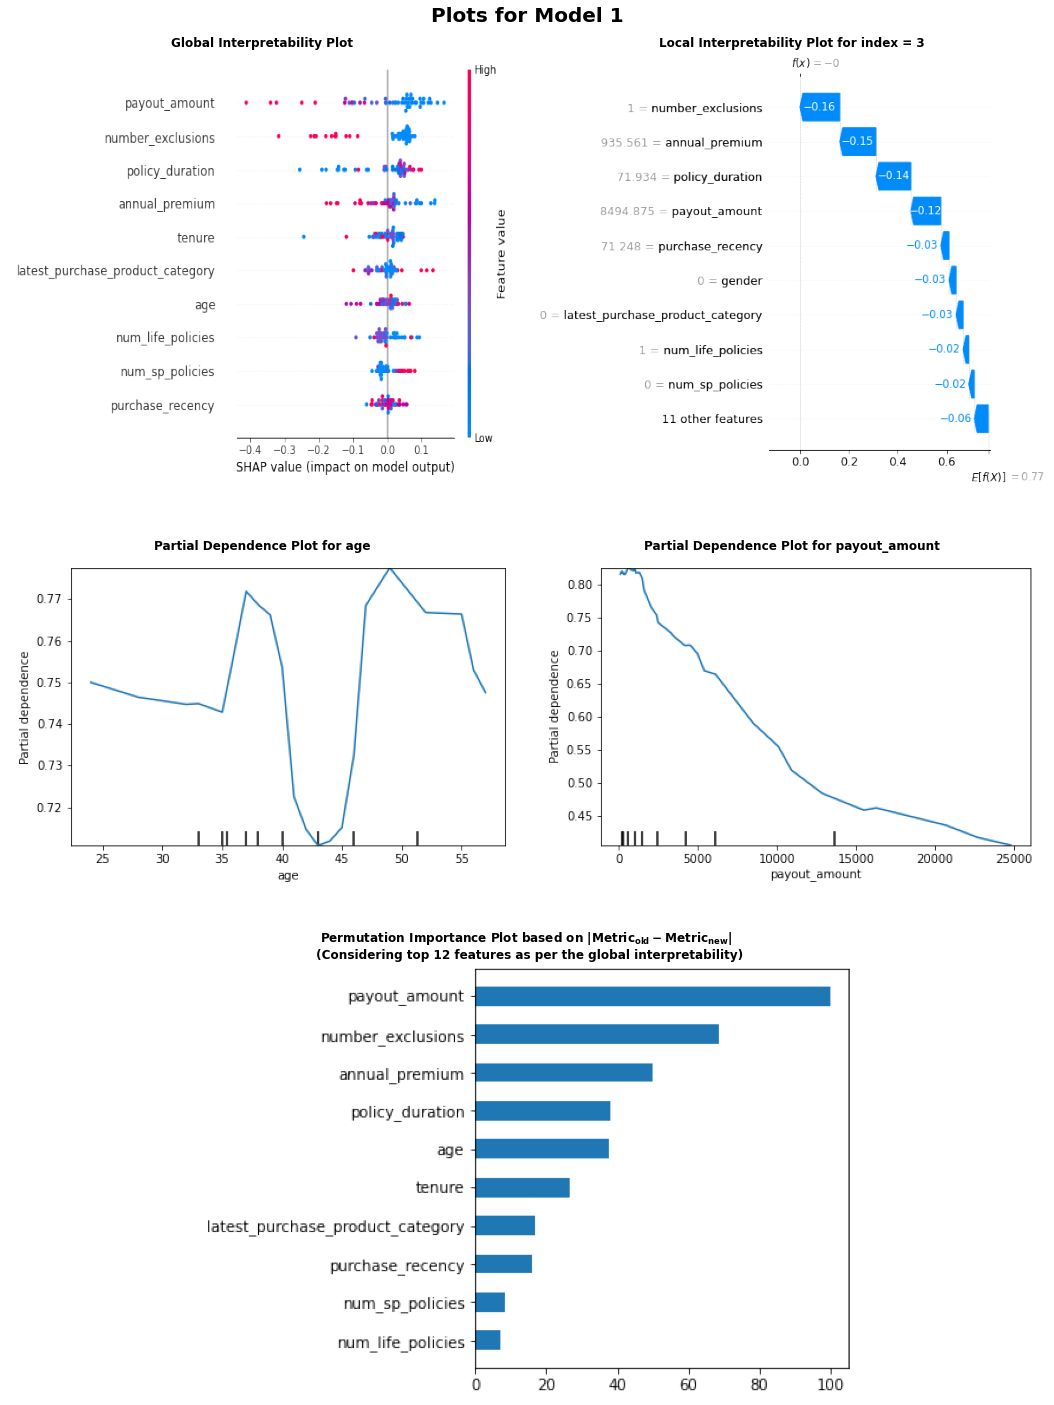

In [88]:
#run the entire transparency analysis 
pred_underwriting_obj.explain()

<h5 align="center">Table 3: Transparency parameters   </h5>

| Var Name    | Description   |  Value        |Default|Compulsory|
| :---        |          ---: |          ---: |---:|---:|
| local_index |index for local interpretability plot |integer   |last value of tran_index |No|
| model_num   |model for which assessment is required |1 or 2   |last model in model container |No|
| output      |boolean value for displaying the plots |True or False   |True |No|





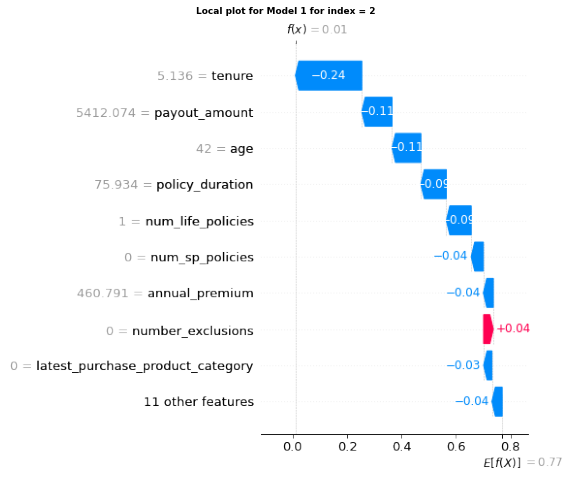

In [89]:
#get the local interpretability plot for specific row index and model
pred_underwriting_obj.explain(local_index = 2)

## Compiling Results

In [90]:
pred_underwriting_obj.compile()

Running evaluate                        done      
     performance measures               done      
     bias detection                     done      
     probability calibration            done      
     performance dynamics               done      
     individual fairness                done      
Running tradeoff                        done      
Running feature importance              done      
     leave-one-out analysis             done      
     correlation analysis               done      
Transparency analysis for model 1       done      
Generating model artifact               done
Saved model artifact to model_artifact_pred_underwriting_20230227_1933.json


## Starting Bias Mitigation

Root cause analysis:   0%|          



                            Top 10 contributors towards bias for class '1.0'    
                         Measured by SHAP-based Demographic Parity on 53 samples




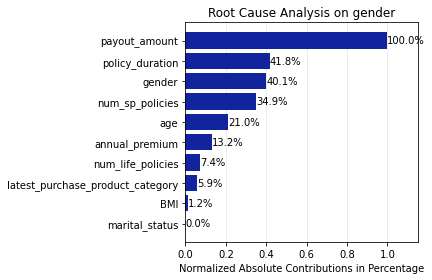

In [91]:
pred_underwriting_obj.rootcause(p_var=['gender'])

In [92]:
mitigated = pred_underwriting_obj.mitigate(p_var=['gender'], method=['threshold', 'reweigh', 'correlate'])

Bias mitigation :   0%|          


*Effective input for p_var = ['gender']

                                Threshold tuning                                

--------------------------------------------------------------------------------
|Protected variable            |Privileged             |Unprivileged           |
--------------------------------------------------------------------------------
|gender                        |0.422                  |0.699                  |
--------------------------------------------------------------------------------


                                   Reweighing                                   

--------------------------------------------------------------------------------
|gender                        |Label                  |Weight                 |
--------------------------------------------------------------------------------
|0                             |0.0                    |1.370                  |
---------------------------------------------------------------

In [ ]:
# y_pred can be used to reinitialise the model container and rerun fairness assessment
y_pred_gender_mitigated = mitigated['threshold'][0]
#y_pred_race_mitigated = mitigated['threshold'][1]

In [ ]:
# sample_weights can be used to reinitialise the model container and rerun fairness assessment
sample_weights_mitigated = mitigated['reweigh'][0]

In [ ]:
# x_train, x_test can be used to reinitialise the model container and rerun fairness assessment
x_train_mitigated = mitigated['correlate'][0]
x_test_mitigated = mitigated['correlate'][1]

New dataset can be transformed using correlation removal as follows.

In [ ]:
# for illustration, a new dataset is being sampled from x_test and y_true
indices = np.random.choice(x_test.index, size=50, replace=False)
x_test_sample = x_test.loc[indices].reset_index(drop=True)
y_true_sample = y_true[indices]
_, _, beta = mitigated['correlate']

In [ ]:
transform_mitigated = pred_underwriting_obj.mitigate(p_var=['gender'], method=['correlate'], cr_alpha=0.9, cr_beta=beta, 
                                           transform_x=x_test_sample)

In [ ]:
# debiased transform_x
transform_mitigated['correlate'][0].head()

#### Bias Mitigated Fairness Assessment

In [94]:
class MitigateWrapper(ModelWrapper):

    def __init__(self, model_obj, th, classes=[0, 1]):
        self.model_obj = model_obj
        self.classes_ = classes        
        self.th = th

    def fit(self, X, y):
            
        self.model_obj.fit(X, y)
  
    
    def predict(self, x_test):
                
        test_probs = self.model_obj.predict_proba(x_test)[:, 1] 
                        
        # Using bias mitigation thresholds
        
        test_preds = np.where(test_probs > self.th, 1, 0)
        
        return test_preds
    
    
    def predict_proba(self, x_test):
        
        return self.model_obj.predict_proba(x_test)
    
    
def get_row_threshold(X, column, groups, thresholds):
    th = np.zeros(len(X), dtype=float)
    
    for g, t in zip(groups, thresholds):
        group_mask = X[column] == g
        th[group_mask] = t
    return th

th = get_row_threshold(x_test_final,"gender",[1, 0],[0.423, 0.699])


In [95]:
rfc_untrained = RandomForestClassifier(random_state=SEED)
model_obj = MitigateWrapper(rfc_untrained, th)

In [96]:
model_obj.fit(x_train_final, y_train_resampled)

In [97]:
mitg_y_pred = model_obj.predict(x_test_final)
# print("Balanced Accuracy: {}".format(round(balanced_accuracy_score(y_true,mitg_y_pred),3)))

mitg_y_prob = model_obj.predict_proba(x_test_final)[:, 1] 

In [98]:
container_mitg = ModelContainer(y_true,  p_grp, model_type, model_name, mitg_y_pred, mitg_y_prob, y_train_resampled, x_train=x_train_final, \
                           x_test=x_test_final, model_object=model_obj, up_grp=up_grp)

pred_underwriting_obj_mitg = PredictiveUnderwriting(model_params = [container_mitg], fair_threshold = 80, fair_concern = "inclusive", \
                                        fair_priority = "benefit", fair_impact = "normal", fair_metric_type='ratio',\
                                               tran_index=[1,2,3], tran_max_sample = 50, tran_max_display = 10, \
                                                      tran_pdp_feature = ['age','payout_amount'])

pred_underwriting_obj_mitg.evaluate()

Evaluate performance:   0%|          


Class Distribution
	pos_label                                                          82.681%
	neg_label                                                          17.319%


Performance Metrics
	Selection Rate                                             0.794 +/- 0.012
	Accuracy                                                   0.944 +/- 0.007
	Balanced Accuracy                                          0.939 +/- 0.009
	Recall                                                     0.946 +/- 0.008
	Precision                                                  0.985 +/- 0.004
	F1 Score                                                   0.965 +/- 0.005
	True Negative Rate                                         0.933 +/- 0.017
	False Negative Rate                                        0.054 +/- 0.008
	Negative Predictive Value                                  0.785 +/- 0.027
	ROC AUC Score                                              0.988 +/- 0.003
	Log-loss                                     

In [41]:
#Call evaluate not just balanced accuracy
pred_underwriting_obj_mitg.compile(disable=['evaluate>perf_dynamic|calibration_curve|individual_fair', \
                                      'feature_importance>correlation', 'explain'])

Running evaluate                        done      
     performance measures               done      
     bias detection                     done      
     probability calibration            done      
     performance dynamics               done      
     individual fairness                done      


Tradeoff:   0%|          


Running tradeoff                        done      


Feature importance:   0%|          


Running feature importance              done      
     leave-one-out analysis             done      
     correlation analysis               skipped   
Running transparency                    skipped   
Generating model artifact               done
Saved model artifact to model_artifact_pred_underwriting_20230227_1440.json
